In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import os
import scanpy as sc
%matplotlib inline

### UMI 5

In [8]:
###### read in this tsv .to_csv('/data/tbaharav/umi_dyla
# n/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=False, index=False)
umi_probs = pd.read_csv('/data/tbaharav/umi_dylan/umi_analysis/umi_probs_length_5.tsv', sep='\t', header=None)
umi_probs.columns = ['umi', 'prob']

In [9]:
umi_prob_arr = np.array(umi_probs['prob'])

In [10]:
######## forward model for computing expected number of collided UMIs given true n_umis, and an empirical distribution of UMI probabilities
def compute_non_unif_estimator(umi_prob_arr, n_umis_true,K):
    """
    Compute the estimator for non-collided UMI counts.
    
    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): True number of UMIs.
    K (int): Total number of UMIs.
    """
    
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must be equal to K"
    # assert n_umis_true <= K, "n_umis_true must be less than or equal to K"
    
    # Compute the expected number of UMIs from collisions
    
    return K - np.sum( (1-umi_prob_arr)**n_umis_true )
    
    
def compute_naive_unif_estimator(n_umis_true, K):
    """
    Compute the naive estimator for non-collided UMI counts.
    """
    return K * (1 - (1 - 1 / K)**n_umis_true)

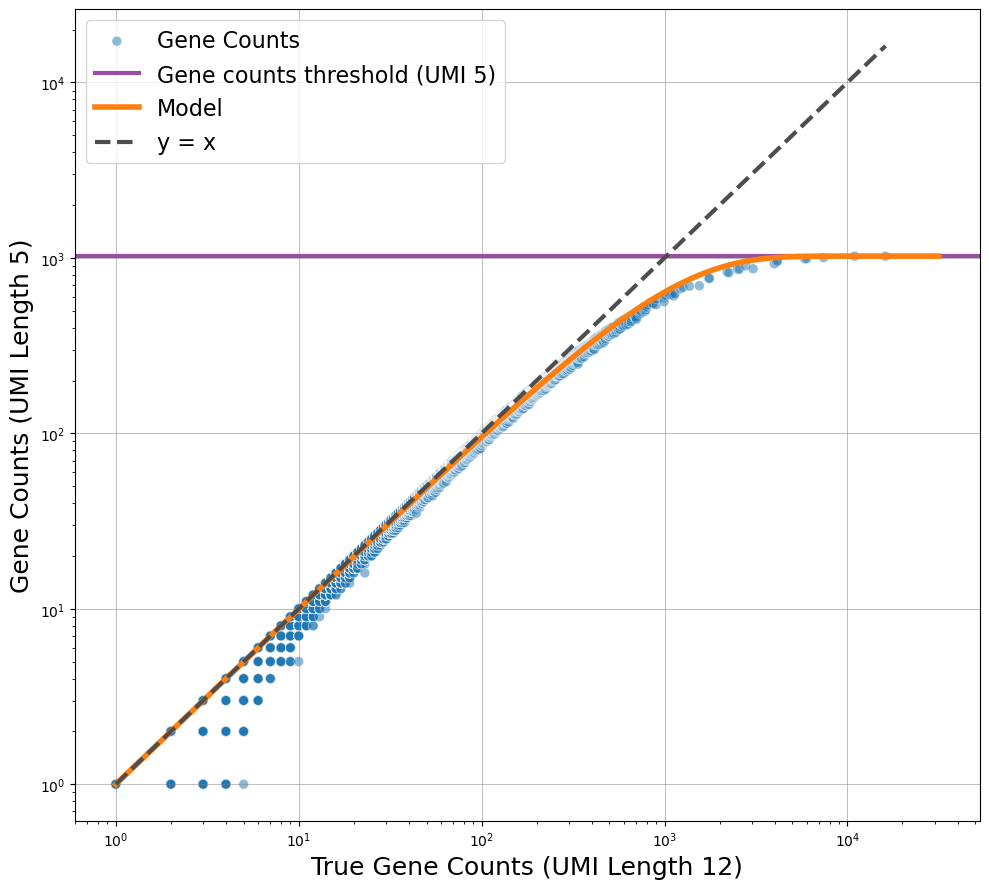

In [88]:
###### Dylan initial plotting code

# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 1k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/"  # Directory for 1k_PBMCs



directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"  # Directory for 10k_PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k PBMCs


# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ub_objects/adata_matrices/"  # Directory for 500 PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/500_PBMCs/ur_objects/adata_matrices/"  # Directory for 500 PBMCs



# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ub_objects/adata_matrices/"  # Directory for 5k_PBMCs
# directory = "/data/dagyeman/cellranger/bam_file_analysis/5k_PBMCs/ur_objects/adata_matrices/"  # Directory for 5k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    






# Your model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
j = 5  # Fixed comparison UMI length
# barcode = "TGTATCTCAGGAATCT-1" # 5k PBMCs 
# barcode = "CAGCAGCTCTCCAATT-1" # 500 PBMCs
n_values = np.logspace(0, 4.5, 200)

min_ct_threshold = 1

# Output directory
# save_dir = "/data/dagyeman/cellranger/bam_file_analysis/figures_ur/counts_plots/naive"
# os.makedirs(save_dir, exist_ok=True)

# Find the barcode index
# index_i = np.where(adata_dict[i].obs_names == barcode)[0][0]
# index_j = np.where(adata_dict[j].obs_names == barcode)[0][0]

# # Extract and process counts
# gene_counts_i = adata_dict[i].X[index_i].flatten()
# gene_counts_j = adata_dict[j].X[index_j].flatten()

gene_counts_i = adata_dict[i].X.flatten()
gene_counts_j = adata_dict[j].X.flatten()

mask = gene_counts_i >= min_ct_threshold
gene_counts_i = gene_counts_i[mask]
gene_counts_j = gene_counts_j[mask]

sorted_idx = np.argsort(gene_counts_i)
sorted_gene_counts_i = gene_counts_i[sorted_idx] #+ 1
sorted_gene_counts_j = gene_counts_j[sorted_idx] #+ 1

# Create plot
plt.figure(figsize=(10, 9))

# Compute colors based on condition
colors = ["red" if sorted_gene_counts_j[i] - f(sorted_gene_counts_j[i], j) < -40 else '#1f77b4' for i in range(len(sorted_gene_counts_i)) ]


plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')

y_asymptotic_value = 4**j
plt.axhline(y=y_asymptotic_value, color='#984ea3', linestyle='-', linewidth=3, label=f'Gene counts threshold (UMI {j})')

model_vals = f(n_values, j)
plt.plot(n_values, model_vals, color='#ff7f0e', linewidth=4, label='Model')

######### also plot results from compute_non_unif_estimator
# K = 4**j
# non_unif_prediction = [compute_non_unif_estimator(umi_prob_arr, n, K) for n in n_values]
# plt.plot(n_values, non_unif_prediction, color='#2ca02c', linewidth=4, label='Non-uniform estimator')



max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_i.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=3, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=18)
plt.ylabel(f'Gene Counts (UMI Length {j})', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.7)
plt.legend(fontsize=16, loc = "upper left")
plt.tight_layout()

plt.show()

In [74]:
###### center plot by subtracting model_vals
K = 4**j
plt.figure()
naive_pred = f(sorted_gene_counts_i,j)
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
#            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts')
# plt.plot(sorted_gene_counts_i, naive_pred - opt_pred, color='#ff7f0e', linewidth=4, label='uniform minus non-uniform predictions')

# plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - naive_pred, alpha=0.5, 
#             c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Counts - Naive')

## Uniform one


<Figure size 640x480 with 0 Axes>

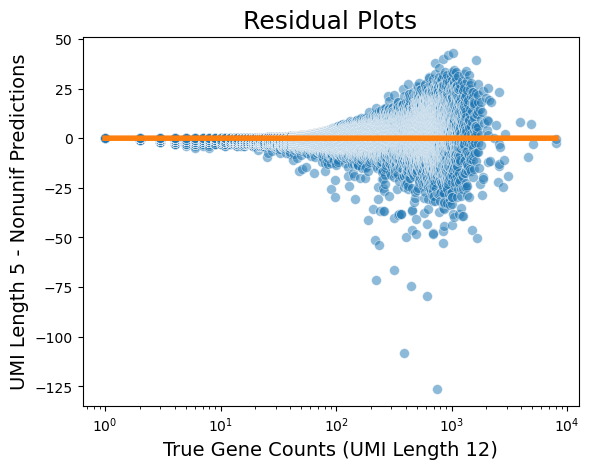

In [71]:
plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
            c='#1f77b4', edgecolors='w', s=50, linewidth=0.5, label='Gene Count (UMI Length {j}) - opt_pred')
plt.plot(sorted_gene_counts_i, opt_pred-opt_pred, color='#ff7f0e', linewidth=4, label='Zero Line')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=14)
plt.ylabel(f'UMI Length {j} - Nonunif Predictions', fontsize=14)
# plt.legend(fontsize=12, loc="lower left", ncol=1, bbox_to_anchor=(0, 0, 0.5, 1))
plt.title(f'Residual Plots', fontsize=18)

plt.xscale('log')

### Same plots but trying to identify the outliers

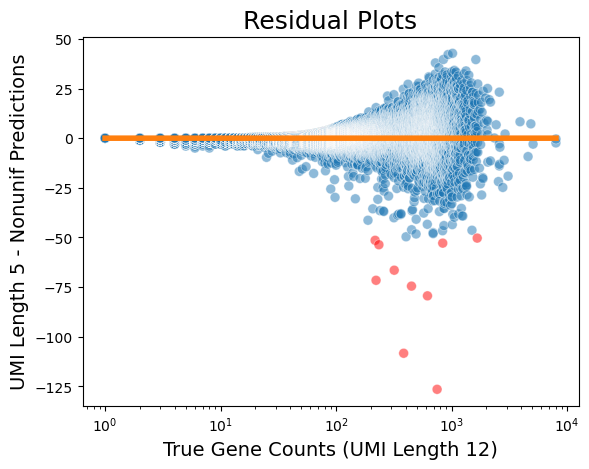

In [72]:
y_values = sorted_gene_counts_j - opt_pred

outlier_threshold = -50
colors = ["red" if y < outlier_threshold else '#1f77b4' for y in y_values]

plt.scatter(sorted_gene_counts_i, sorted_gene_counts_j - opt_pred, alpha=0.5, 
            c=colors, edgecolors='w', s=50, linewidth=0.5, label='Gene Count (UMI Length {j}) - opt_pred')
plt.plot(sorted_gene_counts_i, opt_pred-opt_pred, color='#ff7f0e', linewidth=4, label='Zero Line')
plt.xlabel('True Gene Counts (UMI Length 12)', fontsize=14)
plt.ylabel(f'UMI Length {j} - Nonunif Predictions', fontsize=14)
# plt.legend(fontsize=12, loc="lower left", ncol=1, bbox_to_anchor=(0, 0, 0.5, 1))
plt.title(f'Residual Plots', fontsize=18)

plt.xscale('log')

## Findng the outlier points

#### Identifying the points

In [89]:
import pandas as pd

# Filter points where the difference is < -40
opt_pred = np.array([compute_non_unif_estimator(umi_prob_arr, n, K) for n in sorted_gene_counts_i])
filtered_indices = [i for i in range(len(sorted_gene_counts_i)) if sorted_gene_counts_j[i] - opt_pred[i] < -40]

# Create a DataFrame with the filtered counts
filtered_data = pd.DataFrame({
    'sorted_gene_counts_i': sorted_gene_counts_i[filtered_indices],
    'sorted_gene_counts_j': sorted_gene_counts_j[filtered_indices],
    'difference': sorted_gene_counts_j[filtered_indices] - f(sorted_gene_counts_i[filtered_indices], j)
})

print(filtered_data)

   sorted_gene_counts_i  sorted_gene_counts_j  difference
0                 703.0                 447.0  -61.770242
1                 995.0                 563.0  -73.654385
2                1124.0                 607.0  -75.523371
3                1550.0                 694.0 -104.783908
4                2248.0                 823.0  -87.126671
5                2567.0                 862.0  -78.619787
6                3052.0                 868.0 -104.088165
7                3988.0                 925.0  -78.198238


### Obtaining the dataframe

In [90]:


directory = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ub_objects/adata_matrices/"  # Directory for 10k_PBMCs

adata_dict = {}
for i in range(1, 13):
    adata_dict[i] = sc.read_h5ad(directory + f"adata_{i}.h5ad")
    
adata_5 = adata_dict[5]
adata_12 = adata_dict[12]

import pandas as pd
import numpy as np

# Your count pairs
count_pairs = [
   (703.0, 447.0),
    (995.0, 563.0),
    (1124.0, 607.0),
    (1550.0, 694.0),
    (2248.0, 823.0),
    (2567.0, 862.0),
    (3052.0, 868.0),
    (3988.0, 925.0)
]

# Extract X matrices as dense arrays for fast filtering
X_12 = adata_12.X.toarray() if not isinstance(adata_12.X, np.ndarray) else adata_12.X
X_5 = adata_5.X.toarray() if not isinstance(adata_5.X, np.ndarray) else adata_5.X

# Create DataFrames for easy indexing
df_12 = pd.DataFrame(X_12, index=adata_12.obs_names, columns=adata_12.var_names)
df_5 = pd.DataFrame(X_5, index=adata_5.obs_names, columns=adata_5.var_names)

results = []

# Loop through each count pair efficiently
for c12, c5 in count_pairs:
    # Find locations in adata_12 matching c12
    idx_12, gene_idx_12 = np.where(df_12.values == c12)
    for i, j in zip(idx_12, gene_idx_12):
        cell = df_12.index[i]
        gene = df_12.columns[j]
        # Confirm matching value in adata_5
        if df_5.loc[cell, gene] == c5:
            results.append({
                "barcode": cell,
                "gene": gene,
                "count_12": c12,
                "count_5": c5
            })

# Convert to DataFrame for clear output
results_df = pd.DataFrame(results)


# Optionally, print for immediate viewing
print(results_df)

              barcode    gene  count_12  count_5
0  CGAGGCTAGCCTATCA-1  MALAT1     703.0    447.0
1  GGACGTCAGGGTGAAA-1  S100A9     703.0    447.0
2  CTGAGCGAGTTGGAGC-1   IGLC3     995.0    563.0
3  TCCATCGCAGACCCGT-1   IGHG1    1124.0    607.0
4  TTGGATGAGATCGCTT-1   IGHA1    1550.0    694.0
5  GCCATGGAGTCTGCAT-1    IGKC    2248.0    823.0
6  TCGCAGGTCCTACCGT-1    IGKC    2567.0    862.0
7  TTGGATGAGATCGCTT-1    IGKC    3052.0    868.0
8  CTTCAATCACTGTGTA-1    IGKC    3988.0    925.0


#### Trailing T stuff

In [1]:
import pysam
import pandas as pd

# Path to the filtered BAM file
filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/filtered_1k_PBMCS_bam.bam' # filtered path for 1k dataset 
# filtered_bam_path = '/data/dagyeman/cellranger/bam_file_analysis/filtered_10k_PBMCS_bam.bam' # filtered bam path for 10k dataset

# List to store rows of data (barcode, gene, UMI)
data = []

# Open the filtered BAM file for reading
with pysam.AlignmentFile(filtered_bam_path, "rb") as bam_file:
    # Iterate over each read in the BAM file
    for read in bam_file:
        # Check if the read has 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
        if read.has_tag('CB') and read.has_tag('GN') and read.has_tag('UB'):
            # Extract the 'CB' (cell barcode), 'GN' (gene name), and 'UB' (UMI) tags
            barcode = read.get_tag('CB')
            gene = read.get_tag('GN')
            umi = read.get_tag('UB')
            
            # Append the row to the data list
            data.append([barcode, gene, umi])

# Convert the list into a pandas DataFrame
df = pd.DataFrame(data, columns=['barcode', 'gene', 'UMI'])


# Filter out UMIs that contain 'N'
df = df[~df['UMI'].str.contains('N')]


# Show the first few rows of the DataFrame
print(df.head())

              barcode        gene           UMI
0  GCTGCAGGTTGACGGA-1  AL627309.1  ATGAATTCGTTT
1  GCTGCAGGTTGACGGA-1  AL627309.1  ATGAATTCGTTT
2  CTGCCTATCTTGATTC-1  AL627309.1  CGGGTACTGCGC
3  GCGAGAAAGTTGTAGA-1  AL627309.1  TTGTAAAATACG
4  GGTCTGGTCAGACATC-1  AL627309.1  GGAAATCTGCGT


### Looking at a Gene of Interest

In [2]:
dedup_df = df[["barcode", "gene", "UMI"]].drop_duplicates()

In [3]:
genes = dedup_df["gene"].unique().tolist()
genes

['AL627309.1',
 'AL627309.1;AL627309.3',
 'AL627309.3',
 'AL627309.5',
 'AP006222.2',
 'LINC01409',
 'FAM87B',
 'LINC01128',
 'LINC00115',
 'FAM41C',
 'AL645608.6',
 'AL645608.2',
 'AL645608.2;AL645608.4',
 'AL645608.4',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'AL645608.7',
 'HES4',
 'ISG15',
 'AL645608.1',
 'AGRN',
 'AGRN;AL645608.5',
 'RNF223',
 'C1orf159',
 'AL390719.3',
 'LINC01342',
 'TTLL10',
 'TTLL10-AS1',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'AL162741.1',
 'UBE2J2',
 'LINC01786',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'INTS11;AL139287.1',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20-AS1',
 'MRPL20',
 'AL391244.2',
 'ANKRD65',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'AL645728.1',
 'FNDC10',
 'AL691432.4',
 'AL691432.2',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'FO704657.1',
 'SLC35E2B',
 'CDK11A',
 'SLC35E2A',
 'NADK',
 'GNB1',
 'AL109917.1',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'AL590822.2',
 'PRKCZ-AS1',
 '

In [4]:


gene_of_interest1 = "MT-CO1"
gene_of_interest2 = "MALAT1"
gene_of_interest3 = "S100A9"
gene_of_interest4 = "IGHG1"
# Get all rows matching the gene 
df_gene1 = dedup_df[dedup_df['gene'] == gene_of_interest1]
df_gene2 = dedup_df[dedup_df['gene'] == gene_of_interest2]
df_gene3 = dedup_df[dedup_df['gene'] == gene_of_interest3]
df_gene4 = dedup_df[dedup_df['gene'] == gene_of_interest4]



In [8]:
df_gene2.columns
df_gene2["UMI"].tolist()

['AACCTAGCGAGC',
 'ATTGGTTGTCTG',
 'TATTATAATTAT',
 'CGGCTGTTATTG',
 'CAGCGTGCTACG',
 'TTGTATATTTTC',
 'TCCGCCGCCCGA',
 'GCTTAAATTTGT',
 'GCTAGTCAACTC',
 'GGAGGCCCCCCG',
 'CTGCCCGGGTTT',
 'AATTAACGTCCT',
 'TAGGGTGTAAGC',
 'TTGAATGCCTCA',
 'GTTACCGACCTA',
 'ATCCTTTGATAG',
 'ACCGTTAGGGTT',
 'CTTCTTAAATGC',
 'TTCATCAGTTAT',
 'CCTACCCTACGC',
 'AGTTCTTGTATC',
 'CTTCCACTTAAG',
 'TTTCGCCCCCTG',
 'TTCTGCGTAGCA',
 'CCTGCCTCTCGA',
 'ATTTGTTCGTAA',
 'GATTTTTTGGTG',
 'CTCTTCCCGTAA',
 'CGCAAATCTTGT',
 'ACTAAACTGGAG',
 'CAGTATTTTAGT',
 'GCGTTCCCTCAC',
 'ATTATTCACGTG',
 'TCTGAACTTCCT',
 'CCAGTGGACATT',
 'AGCCACGTCTTA',
 'CCTTTTGTAGGG',
 'GCCATGTTTTCG',
 'TATTCAAGGATT',
 'TTACATTTTTCC',
 'TCCTTGCTTTGT',
 'TAAATCAACGTC',
 'CATTTTCGGTGT',
 'TTTCTTCCGTCC',
 'GCATGATTTTGT',
 'TTGCTTTTACTA',
 'CGTCACCCGTAG',
 'TATTCTACCAGG',
 'GGACTTTTTGGC',
 'TATGGCTCACCT',
 'CCCTGTATAGAG',
 'CTTCCATCACTG',
 'ATTGGTCAAGTC',
 'TATGTGTCCTTC',
 'GGCGACTCCAGT',
 'CTGAGTTAAGTA',
 'TACTTGAGTATA',
 'ACACGGGGGTCC',
 'CGGCGTTCTGAC

In [86]:
trailing_T_mask1 = df_gene1["UMI"].str.endswith("T" * 6)
trailing_T_mask2= df_gene2["UMI"].str.endswith("T" * 6)
trailing_T_mask3= df_gene3["UMI"].str.endswith("T" * 6)
trailing_T_mask4= df_gene4["UMI"].str.endswith("T" * 6)
proportion1 = trailing_T_mask1.sum()/len(df_gene1)
proportion2 = trailing_T_mask2.sum()/len(df_gene2)
proportion3 = trailing_T_mask3.sum()/len(df_gene3)
proportion4 = trailing_T_mask4.sum()/len(df_gene4)

In [87]:
proportions = [proportion1, proportion2, proportion3, proportion4]

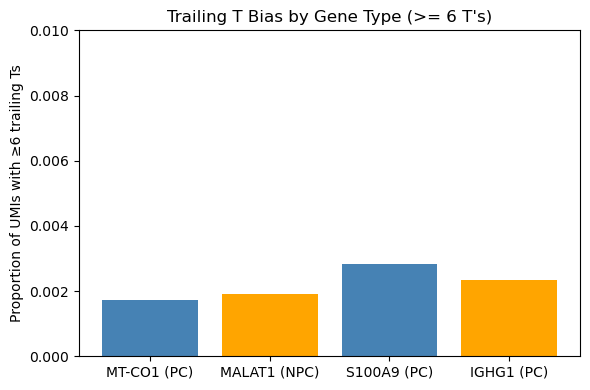

In [90]:
import matplotlib.pyplot as plt

# Bar plot of proportions
labels = ['MT-CO1 (PC)', 'MALAT1 (NPC)', "S100A9 (PC)", "IGHG1 (PC)"]

plt.figure(figsize=(6, 4))
plt.bar(labels, proportions, color=['steelblue', 'orange'])
plt.ylabel("Proportion of UMIs with ≥6 trailing Ts")
plt.title("Trailing T Bias by Gene Type (>= 6 T's)")
plt.ylim(0,0.01)

# Annotate bars with percentages
# for i, v in enumerate(proportions):
#     plt.text(i, v + 0.02, f"{v:.4%}", ha='center', fontsize=10)

plt.tight_layout()

plt.show()

### Identifying the Protein Coding Genes vs. Non protein Codiing

In [24]:
protein_coding_genes = set()
non_protein_coding_genes = set()

gtf_path = "/data/dagyeman/cellranger/refdata-gex-GRCh38-2020-A/genes/genes.gtf"

with open(gtf_path, 'r') as f:
    for line in f:
        if line.startswith("#"):
            continue
        fields = line.strip().split('\t')
        if fields[2] == "gene":
            attributes = fields[8]
            gene_name = ""
            gene_type = ""
            for attr in attributes.strip().split(";"):
                attr = attr.strip()
                if attr.startswith("gene_name"):
                    gene_name = attr.split('"')[1]
                elif attr.startswith("gene_type"):
                    gene_type = attr.split('"')[1]
            if gene_type == "protein_coding":
                protein_coding_genes.add(gene_name)
            elif gene_name:
                non_protein_coding_genes.add(gene_name)

# Save to text files if needed
with open("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", "w") as f:
    f.write("\n".join(sorted(protein_coding_genes)))

with open("/data/dagyeman/cellranger/1k_non_protein_coding_genes.txt", "w") as f:
    f.write("\n".join(sorted(non_protein_coding_genes)))

print(f"Protein-coding genes: {len(protein_coding_genes)}")
print(f"Non-protein-coding genes: {len(non_protein_coding_genes)}")


Protein-coding genes: 19389
Non-protein-coding genes: 17205


In [5]:
protein_coding_genes = np.loadtxt("/data/dagyeman/cellranger/1k_protein_coding_genes.txt", dtype=str)
non_protein_coding_genes = np.loadtxt("/data/dagyeman/cellranger/1k_non_protein_coding_genes.txt", dtype=str)

protein_coding_genes    

array(['A1BG', 'A1CF', 'A2M', ..., 'ZYG11B', 'ZYX', 'ZZEF1'], dtype='<U14')

In [6]:
# Convert to sets for fast lookup
protein_coding_genes = set(protein_coding_genes)
non_protein_coding_genes = set(non_protein_coding_genes)

# Subset deduplicated data by gene type
df_protein = dedup_df[dedup_df["gene"].isin(protein_coding_genes)]
df_non_protein = dedup_df[dedup_df["gene"].isin(non_protein_coding_genes)]

# Define trailing T check (4 or more)
has_6_trailing_Ts = lambda x: x.endswith("TTTTTT")

# Compute proportions
prop_protein = df_protein["UMI"].apply(has_6_trailing_Ts).mean()
prop_non_protein = df_non_protein["UMI"].apply(has_6_trailing_Ts).mean()

# Print results
print(f"Proportion of UMIs with ≥6 trailing Ts:")
print(f"  Protein-coding genes:       {prop_protein:.4f}")
print(f"  Non-protein-coding genes:   {prop_non_protein:.4f}")
print(len(df_protein), len(df_non_protein))

Proportion of UMIs with ≥6 trailing Ts:
  Protein-coding genes:       0.0023
  Non-protein-coding genes:   0.0021
13448487 958717


In [7]:


gene_of_interest1 = "MT-CO1"
gene_of_interest2 = "MALAT1"
gene_of_interest3 = "S100A9"
gene_of_interest4 = "IGHG1"
# Get all rows matching the gene 
df_gene1 = dedup_df[dedup_df['gene'] == gene_of_interest1]
df_gene2 = dedup_df[dedup_df['gene'] == gene_of_interest2]
df_gene3 = dedup_df[dedup_df['gene'] == gene_of_interest3]
df_gene4 = dedup_df[dedup_df['gene'] == gene_of_interest4]



trailing_T_mask1 = df_gene1["UMI"].str.endswith("T" * 6)
trailing_T_mask2= df_gene2["UMI"].str.endswith("T" * 6)
trailing_T_mask3= df_gene3["UMI"].str.endswith("T" * 6)
trailing_T_mask4= df_gene4["UMI"].str.endswith("T" * 6)
proportion1 = trailing_T_mask1.sum()/len(df_gene1)
proportion2 = trailing_T_mask2.sum()/len(df_gene2)
proportion3 = trailing_T_mask3.sum()/len(df_gene3)
proportion4 = trailing_T_mask4.sum()/len(df_gene4)

proportions = [proportion1, proportion2, proportion3, proportion4]




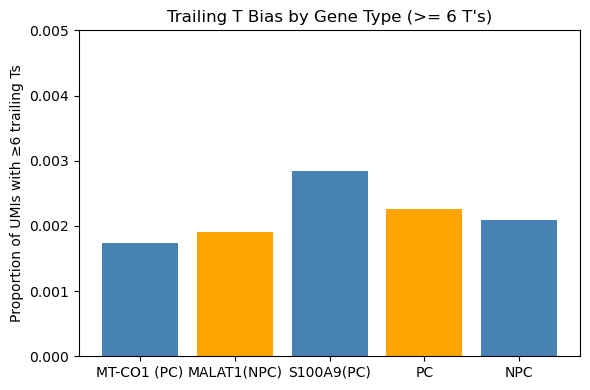

In [15]:
import matplotlib.pyplot as plt

# Bar plot of proportions
labels = ['MT-CO1 (PC)', 'MALAT1(NPC)', "S100A9(PC)",'PC', 'NPC']
proportions = [proportion1, proportion2, proportion3, prop_protein, prop_non_protein]

plt.figure(figsize=(6, 4))
plt.bar(labels, proportions, color=['steelblue', 'orange'])
plt.ylabel("Proportion of UMIs with ≥6 trailing Ts")
plt.title("Trailing T Bias by Gene Type (>= 6 T's)")
plt.ylim(0, 0.005)

# Annotate bars with percentages
# for i, v in enumerate(proportions):
#     plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontsize=10)

plt.tight_layout()

plt.show()
